
# Prediction

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils
ROOT_DIR = "D:\\mcn"
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "log")
MODEL_DIR = os.path.join(ROOT_DIR, "log")
WEIGHTS_PATH = "D:\\mcn\\log\\object20230823T2228\\mask_rcnn_object_0010.h5"   # change it

Using TensorFlow backend.


In [2]:
class CustomConfig(Config):
    NAME = "object"

    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 5
    STEPS_PER_EPOCH = 10
    DETECTION_MIN_CONFIDENCE = 0.9

In [3]:
class CustomDataset(utils.Dataset):
    def load_custom(self, dataset_dir, subset):
        self.add_class("object", 1, "Healthy")
        self.add_class("object", 2, "Mosaic")
        self.add_class("object", 3, "RedRot")
        self.add_class("object", 4, "Rust")
        self.add_class("object", 5, "Yellow")
        assert subset in ["trainS", "valS"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations_file = os.path.join(dataset_dir, f"{subset}.json")
        with open(annotations_file, "r") as f:
            annotations1 = json.load(f)
        annotations = list(annotations1.values())
        annotations = [a for a in annotations if a['regions']]
        for a in annotations:
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['type'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Healthy": 1,"Mosaic": 2,"RedRot":3,"Rust":4,"Yellow":5}
            num_ids = [name_dict[a] for a in objects]
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [4]:
TEST_MODE = "inference"
ROOT_DIR = "D:\\mcn"

def get_ax(rows=1, cols=1, size=16):
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax
CUSTOM_DIR = "D:\\mcn"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "valS")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['Healthy']
numids [1]
objects: ['Healthy']
numids [1]
objects: ['Healthy']
numids [1]
objects: ['Mosaic', 'Mosaic']
numids [2, 2]
objects: ['Mosaic', 'Mosaic']
numids [2, 2]
objects: ['Mosaic', 'Mosaic']
numids [2, 2]
objects: ['RedRot']
numids [3]
objects: ['RedRot']
numids [3]
objects: ['RedRot']
numids [3]
objects: ['Rust']
numids [4]
objects: ['Rust']
numids [4]
objects: ['Rust']
numids [4]
objects: ['Yellow']
numids [5]
objects: ['Yellow', 'Yellow']
numids [5, 5]
objects: ['Yellow', 'Yellow']
numids [5, 5]
Images: 15
Classes: ['BG', 'Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']


In [5]:
import mrcnn.model as modellib
config = CustomConfig()
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [6]:
weights_path = WEIGHTS_PATH
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  D:\mcn\log\object20230823T2228\mask_rcnn_object_0010.h5








Images: 15
Classes: ['BG', 'Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']
Processing 1 images
image                    shape: (493, 1040, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1040.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


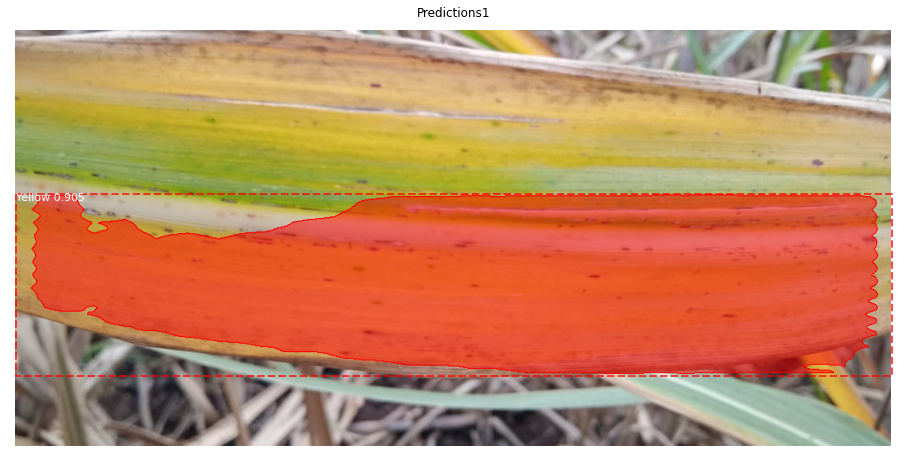

In [20]:
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
path_to_new_image = 'D:\\mcn\\Sugarcane Leaf Disease Dataset\\Yellow\\yellow (2).jpeg'
image1 = mpimg.imread(path_to_new_image)
results1 = model.detect([image1], verbose=1)
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")